## load data and change into h5 files

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import Cooking
import random

C:\Users\Lian\AppData\Local\Temp\ipykernel_26816\4277335563.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Num GPUs Available:  0


In [2]:
RAW_DATA_DIR = 'airsim_data/record/'
COOKED_DATA_DIR = 'data_cooked/'
FIGURE_SIZE = (10,10)
# # The folders to search for data under RAW_DATA_DIR
# # For example, the first folder searched will be RAW_DATA_DIR/normal_1
# DATA_FOLDERS = ['normal_1', 'normal_2', 'normal_3', 'normal_4', 'normal_5', 'normal_6', 'swerve_1', 'swerve_2', 'swerve_3']

In [3]:
data_path = os.path.join(RAW_DATA_DIR, 'airsim_rec.txt')
dataset = pd.read_csv(data_path, sep='\t')
dataset.head()

,VehicleName,TimeStamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,Throttle,Steering,Brake,Gear,Handbrake,RPM,Speed,ImageFile
0,PhysXCar,1714531210499,-0.098852,-0.165773,0.215576,0.866175,-0.014998,-0.050876,0.496917,1,0,0,1,0,1206.85,0.658831,img_PhysXCar__0_1714531210498340000.png
1,PhysXCar,1714531210558,-0.077734,-0.131069,0.215546,0.866172,-0.013388,-0.051480,0.496907,1,0,0,1,0,1328.49,0.836666,img_PhysXCar__0_1714531210557687900.png
2,PhysXCar,1714531210605,-0.057183,-0.097294,0.215257,0.866163,-0.011006,-0.052059,0.496920,1,0,0,1,0,1427.12,0.984562,img_PhysXCar__0_1714531210604528800.png
3,PhysXCar,1714531210652,-0.033121,-0.057834,0.214652,0.866161,-0.007670,-0.052626,0.496927,1,0,0,1,0,1528.78,1.110160,img_PhysXCar__0_1714531210651474000.png
4,PhysXCar,1714531210709,-0.001225,-0.005981,0.213078,0.866241,-0.002407,-0.053366,0.496763,1,0,0,1,0,1656.43,1.174560,img_PhysXCar__0_1714531210708576300.png


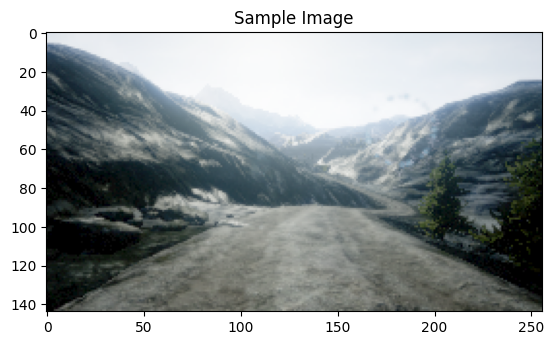

In [5]:
sample_image_path = os.path.join(RAW_DATA_DIR, 'images/img_PhysXCar__0_1714287701007505300.png')
sample_image = Image.open(sample_image_path)
plt.title('Sample Image')
plt.imshow(sample_image)
plt.show()

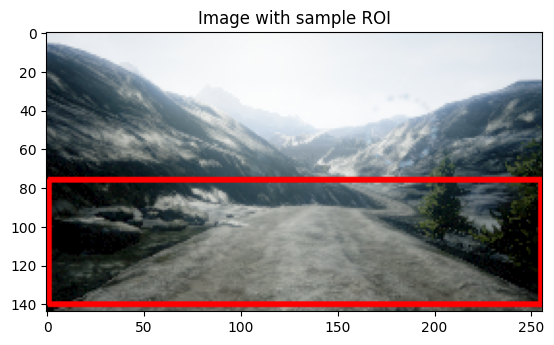

In [6]:
sample_image_roi = sample_image.copy()

fillcolor=(255,0,0)
draw = ImageDraw.Draw(sample_image_roi)
points = [(1,76), (1,140), (255,140), (255,76)]
for i in range(0, len(points), 1):
    draw.line([points[i], points[(i+1)%len(points)]], fill=fillcolor, width=3)
del draw

plt.title('Image with sample ROI')
plt.imshow(sample_image_roi)
plt.show()

In [ ]:
# bins = np.arange(-1, 1.05, 0.05)

# plt.figure(figsize=(5, 5))
# plt.hist(dataset['Throttle'], bins)
# plt.xlabel('Steering Angle')
# plt.ylabel('Normalized Frequency')
# plt.show()

In [11]:
train_eval_test_split = [0.7, 0.2, 0.1]
full_path_raw_folders = [RAW_DATA_DIR]
Cooking.cook(full_path_raw_folders, COOKED_DATA_DIR, train_eval_test_split)

Reading data from airsim_data/record/...
Processing data_cooked/train.h5...
Finished saving data_cooked/train.h5.
Processing data_cooked/eval.h5...
Finished saving data_cooked/eval.h5.
Processing data_cooked/test.h5...
Finished saving data_cooked/test.h5.


## Preprocess data

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from Generator import DriveDataGenerator
from keras.preprocessing import image
import keras.backend as K
import math

MODEL_OUTPUT_DIR = 'model'

In [ ]:
train_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'train.h5'), 'r')
eval_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'eval.h5'), 'r')
test_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'test.h5'), 'r')

num_train_examples = train_dataset['image'].shape[0]
num_eval_examples = eval_dataset['image'].shape[0]
num_test_examples = test_dataset['image'].shape[0]

batch_size=32

In [ ]:
data_generator = DriveDataGenerator(rescale=1./255., horizontal_flip=True, brightness_range=(0.6, 1.4))
train_generator = data_generator.flow\
    (train_dataset['image'], train_dataset['previous_state'], train_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.95, roi=[65,140,0,255])
eval_generator = data_generator.flow\
    (eval_dataset['image'], eval_dataset['previous_state'], eval_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.95, roi=[65,140,0,255])  

In [ ]:

def draw_image_with_label(img, label, prediction=None):
    theta = label * 0.69 #Steering range for the car is +- 40 degrees -> 0.69 radians
    line_length = 50
    line_thickness = 3
    label_line_color = (255, 0, 0)
    prediction_line_color = (0, 0, 255)
    pil_image = image.array_to_img(img, K.image_data_format(), scale=True)
    print('Actual Steering Angle = {0}'.format(label))
    draw_image = pil_image.copy()
    image_draw = ImageDraw.Draw(draw_image)
    first_point = (int(img.shape[1]/2),img.shape[0])
    second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
    image_draw.line([first_point, second_point], fill=label_line_color, width=line_thickness)
    
    if (prediction is not None):
        print('Predicted Steering Angle = {0}'.format(prediction))
        print('L1 Error: {0}'.format(abs(prediction-label)))
        theta = prediction * 0.69
        second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
        image_draw.line([first_point, second_point], fill=prediction_line_color, width=line_thickness)
    
    del image_draw
    plt.imshow(draw_image)
    plt.show()

[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
for i in range(0, 3, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i])

## Train with Kera

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, Input, concatenate
from keras.layers import BatchNormalization
from tensorflow.keras.layers import ELU
from keras.optimizers import Adam, SGD, Adamax, Nadam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping, ProgbarLogger


In [ ]:

image_input_shape = sample_batch_train_data[0].shape[1:]
state_input_shape = sample_batch_train_data[1].shape[1:]
activation = 'relu'

#Create the convolutional stacks
pic_input = Input(shape=image_input_shape)

img_stack = Conv2D(16, (3, 3), name="convolution0", padding='same', activation=activation)(pic_input)
img_stack = MaxPooling2D(pool_size=(2,2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution1')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution2')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Flatten()(img_stack)
img_stack = Dropout(0.2)(img_stack)

#Inject the state input
state_input = Input(shape=state_input_shape)
merged = concatenate([img_stack, state_input])

# Add a few dense layers to finish the model
merged = Dense(64, activation=activation, name='dense0')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(10, activation=activation, name='dense2')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1, name='output')(merged)

adam = Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model = Model(inputs=[pic_input, state_input], outputs=merged)
model.compile(optimizer=adam, loss='mse')

In [ ]:
model.summary()

In [ ]:
plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
checkpoint_filepath = os.path.join(MODEL_OUTPUT_DIR, 'models', '{0}_model.{1}-{2}.h5'.format('model', '{epoch:02d}', '{val_loss:.7f}'))
Cooking.checkAndCreateDir(checkpoint_filepath)
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks=[plateau_callback, csv_callback, checkpoint_callback, early_stopping_callback, ProgbarLogger()]

In [ ]:
history = model.fit(train_generator, steps_per_epoch=num_train_examples//batch_size, epochs=100, callbacks=callbacks,\
                   validation_data=eval_generator, validation_steps=num_eval_examples//batch_size, verbose=2)

In [ ]:
[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
predictions = model.predict([sample_batch_train_data[0], sample_batch_train_data[1]])
for i in range(5, 8, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i], predictions[i])

In [ ]:
df_loss = pd.read_csv(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))

# Extract the 'loss' and 'val_loss' columns
train_loss = df_loss['loss']
val_loss = df_loss['val_loss']

# Plot the data
plt.plot(train_loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Test performace